In [4]:
# Standard library imports
import random

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from scipy.special import comb
from scipy.optimize import fsolve

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
#Custom colormaps
sunset = [
    "#a50026", "#d73027", "#f46d43", "#fdae61", "#fee090", "#e0f3f8", "#abd9e9", "#74add1", "#4575b4", "#313695"
]

ptog = [
    "#40004b", "#762a83", "#9970ab", "#c2a5cf", "#e7d4e8",
    "#d9f0d3", "#a6dba0", "#5aae61", "#1b7837", "#00441b"
]

# General definitions

In [7]:
def compute_Pm(J):
    N = J.shape[0]
    dp = torch.zeros(2 * N + 1, dtype=J.dtype, device=J.device)
    dp[N] = 1.0
    m_vector = torch.arange(-N, N + 1, dtype=J.dtype, device=J.device)
    for l in range(N):
        new_dp = torch.zeros_like(dp)
        up = torch.sigmoid(2 * J[l] * m_vector[:-1])
        new_dp[1:] += dp[:-1] * up
        down = 1 - torch.sigmoid(2 * J[l] * m_vector[1:])
        new_dp[:-1] += dp[1:] * down
        dp = new_dp
    return dp.to(device)

In [8]:
import torch

def transition_matrix_global(probMADE, beta, N):
    device = probMADE.device
    M = len(probMADE)  # M should be N/2 + 1
    
    # Compute m values and their squares: m_i = 2*i/N, with m_max = 1
    m_vals = torch.arange(M, dtype=torch.float64, device=device) * (2.0 / N)
    m2 = m_vals ** 2

    # Precompute the configuration counts (degeneracies) using lgamma for a vectorized comb
    # For i=0: config[0] = comb(N, N//2), and for i>0: config[i] = 2 * comb(N, (N//2) + i)
    indices = torch.arange(M, dtype=torch.float64, device=device)
    k = (N // 2) + indices  # k-values: starting from N//2
    N_tensor = torch.tensor(N, dtype=torch.float64, device=device)
    comb_k = torch.exp(torch.lgamma(N_tensor + 1) - torch.lgamma(k + 1) - torch.lgamma(N_tensor - k + 1))
    config = comb_k.clone()
    if M > 1:
        config[1:] = 2 * config[1:]
    
    # Compute the exponent matrix for all (i, j)
    # exponent[i,j] = 0.5 * beta * N * (m_vals[j]^2 - m_vals[i]^2)
    exponent_matrix = 0.5 * beta * N * (m2[None, :] - m2[:, None])
    exp_matrix = torch.exp(exponent_matrix)
    
    # Compute the ratio matrix (for all i, j):
    # ratio[i,j] = exp_matrix[i,j] * (probMADE[i]*config[j])/(probMADE[j]*config[i])
    ratio = exp_matrix * ((probMADE[:, None] * config[None, :]) / (probMADE[None, :] * config[:, None]))
    
    # Apply the min operation elementwise to get alpha: alpha[i,j] = min(1, ratio[i,j])
    ones = torch.ones_like(ratio)
    alpha = torch.minimum(ones, ratio)
    
    # Off-diagonals: set T[i,j] = probMADE[j] * alpha[i,j]
    T = probMADE[None, :] * alpha
    
    # Exclude the diagonal from the sum and then define T[i,i] = 1 - sum_{j != i} T[i,j]
    # First, zero out the diagonal values in T (they are not used in the off-diagonal sum)
    T.fill_diagonal_(0)
    diag = 1 - T.sum(dim=1)
    T.diagonal(dim1=0, dim2=1).copy_(diag)
    
    return T


# transition matrix for the Markov chain
def transition_matrix_local(N, beta):
    """
    Get the transition matrix for the system in magnetization space.

    Parameters:
    - N (int): The number of spins in the system.
    - beta (float): The inverse temperature (1/kT) of the system.

    Returns:
    - torch.Tensor: A transition matrix of shape ((N/2)+1, (N/2)+1) representing 
                  the probabilities of transitioning between different magnetization states.
    """
    M = int(N / 2) + 1
    P = torch.zeros((M, M), device=device, dtype=torch.float64)

    m_vals = torch.arange(M, dtype=torch.float64, device=device) * (2.0 / N)

    for i in range(M):
        m = m_vals[i]
        if i == 0:
            P[i, 1] = 1.0
        else:
            P[i, i - 1] = (1 + torch.abs(m)) / 2 * torch.exp(-2 * beta * (torch.abs(m) - 1 / N))
            P[i, i] = 1 - (1 + torch.abs(m)) / 2 * torch.exp(-2 * beta * (torch.abs(m) - 1 / N)) - (1 - torch.abs(m)) / 2
            if i != M - 1:
                P[i, i + 1] = (1 - torch.abs(m)) / 2

    return P

In [9]:
def compute_Pm_abs(N, W):
    Neff = int(N/2)
    probMADE = compute_Pm(torch.tensor(W).to(device))[::2]
    x = probMADE[Neff:]
    x[1:] += torch.flip(probMADE[:Neff], dims=[0])
    probMADE = x
    return probMADE

def get_matrix_mixed(N, beta_target, W, k):
    probMADE = compute_Pm_abs(N, W)
    Tmade = transition_matrix_global(probMADE, beta_target, N)
    Tlocal = transition_matrix_local(N, beta_target)
    T = torch.matmul(Tmade, torch.matrix_power(Tlocal, N * k).to(device))
    return T

In [10]:
def mhat(beta):
    """
    Solves the equation m = tanh(beta * m) for m as a function of beta.

    Parameters:
    - beta (float): The value of beta.

    Returns:
    - float: The solution for m.
    """
    # Define the self-consistent equation
    def self_consistent_eq(m):
        return m - np.tanh(beta * m)
    
    # Initial guess for m
    m_initial = 0.5
    
    # Solve the equation using fsolve
    m_solution = fsolve(self_consistent_eq, m_initial)
    
    return m_solution[0]

# Comparison with the simulations

## Definitions

In [11]:
class AutoregressiveMasking(object):
    """Autoregressive constraint for weight matrices."""
    def __init__(self, frequency=1):
        """
        Constructor for AutoregressiveMasking.

        Parameters:
        - frequency (int): Controls how often the autoregressive constraint is applied.
        """
        self.frequency = frequency

    def __call__(self, module):
        """
        Applies the autoregressive constraint to the weight matrices of a module.

        Parameters:
        - module: PyTorch module to which the constraint is applied.
        """
        # Apply autoregressive constraint to weight matrices
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = torch.tril(w, -1)  # Apply lower triangular masking
            module.weight.data = w

# Build the autoregressive model
class made(nn.Module):
    """Autoregressive MADE (Masked Autoencoder for Distribution Estimation)."""
    def __init__(self, input_size):
        """
        Constructor for the MADE model.

        Parameters:
        - input_size (int): Size of the input features.
        """
        super(made, self).__init__()
        self.layer = nn.Linear(input_size, input_size, bias=False)
        # self.constraint = AutoregressiveConstraint()  # Commented out, not used in forward pass
        self.activation = nn.Sigmoid()

    def forward(self, x):
        """
        Forward pass of the MADE model.

        Parameters:
        - x: Input tensor to the model.

        Returns:
        - x: Output tensor after the forward pass.
        """
        x = self.layer(x)
        # x = self.constraint(x)  # Commented out, not used in the forward pass
        x = self.activation(2 * x)  # Apply activation function
        if device == "cuda":
            torch.cuda.empty_cache()  # Clear GPU cache
        return x
    
    def forward_n(self, input, n):
        # Get the n-th row of the weight matrix of the linear layer
        nth_row = self.layer.weight[n]
        x = torch.einsum("ij, j->i", input[:, :n], nth_row[:n])
        x = self.activation(2 * x)
        return x

In [12]:
def setup_model(W, N = 100):
    model = made(N)
    weights = model.layer.weight.detach()

    # Update each row i of the weight matrix with W[i]
    for i in range(weights.shape[0]):
        weights[i, :] = W[i]

    # Set the upper triangular part of the matrix to 0
    weights = np.tril(weights, -1)  # Keep only the lower triangular part

    # Set the updated weights back to the model
    model.layer.weight.data = torch.tensor(weights)
    model = model.cuda()
    return model

In [13]:
def generate_config_fast(model, N_spins, N_config, J):
    """
    Generate N_config spin configurations with N_spins using the MADE.

    Parameters:
    - model: Autoregressive model used for spin generation.
    - N_spins: Number of spins in each configuration.
    - N_config: Number of configurations to generate.

    Returns:
    - Tensor: A tensor containing generated spin configurations with shape (N_config, N_spins).
    """

    with torch.no_grad():
        # Initialize a tensor with random binary configurations (values of -1 or 1)
        #config = (torch.bernoulli(torch.full((N_config, N_spins), 0.5)) * 2 - 1).to("cuda")
        #config = torch.ones((N_config, N_spins)).to("cuda")
        config = torch.zeros((N_config, N_spins)).to("cuda")
    
        # Generate each spin in an autoregressive manner
        for n in range(N_spins):
            # Get probabilities from the autoregressive model for the nth spin
            probs = model.forward_n(config, n)
            
            # Sample new spin values based on probabilities and update the configuration
            config[:, n] = (torch.bernoulli(probs) * 2 - 1)
            torch.cuda.empty_cache()
    
    return config

def MLMC_fast(model, data, beta, N,  num_steps = 10, return_correlations = False):
    # NOTA: le correlazioni sono calcolate usando come riferimento il primo campione
    # Non sono mediate sui tempi!
    #Se il primo campione è all'equilibrio, non ci sono problemi
    acc_rates = []
    if return_correlations:
        correlations = [1]
    with torch.no_grad():
        bce = nn.BCELoss(reduction = "none")
        current_config = data.clone()
        for t in range(num_steps):
            new_config = generate_config_fast(model, N, len(data), None)
            
            current_energy = -N*current_config.mean(1)**2/2
            current_probability = torch.sum(bce(model(current_config), (current_config+1)/2), axis = 1)

            new_energy = -N*new_config.mean(1)**2/2
            new_probability = torch.sum(bce(model(new_config), (new_config+1)/2), axis = 1)

            arg_new = -beta*new_energy + new_probability
            arg_current = -beta*current_energy + current_probability

            acceptances = (torch.log(torch.rand(size=(len(data),), device = "cuda")) < (arg_new-arg_current)).int()
            current_config = torch.einsum("i, ij->ij",(1-acceptances),current_config) + torch.einsum("i, ij->ij",acceptances, new_config)
            torch.cuda.empty_cache()
            acc_rates.append(torch.sum(acceptances)/len(data))
            if return_correlations:
                correlations.append(float(torch.mean(data*current_config) - torch.mean(data)*torch.mean(current_config)))
    if return_correlations:
        return current_config, acc_rates, correlations
    else:
        return current_config, acc_rates

def monte_carlo_update_CW(pop, N, beta):
    """Monte Carlo update model using a checkerboard pattern."""
    population = pop.clone()
    pop_size, N = population.shape
    # Define "even" and "odd" indices for a checkerboard update

    # Update spins in two passes (checkerboard pattern)
    random_indices = torch.randint(0, N, (pop_size,))
    magnetizations = population.mean(1)
    sigmas = population[torch.arange(pop_size), random_indices]
    
    # Compute energy difference for each single-spin flip
    delta_E = -2*(1/N - sigmas*magnetizations)
    # Metropolis acceptance criterion for each spin
    acceptance_prob = torch.exp(-beta * delta_E)
    random_vals = torch.rand(pop_size, device=population.device)
    accept = (delta_E < 0) | (random_vals < acceptance_prob)
    
    # Apply accepted flips only for accepted positions
    population[torch.arange(pop_size), random_indices] = torch.where(accept, -sigmas, sigmas)
    return population

In [14]:
def montecarlo_alternated_abs(N, beta, target_M, model, pop_size = 10000, k = 1):
    # Population of spins, randomly initialized to -1 or 1
    pop = torch.cat([torch.ones((pop_size, N//2)), -torch.ones((pop_size, N//2))], dim=1).cuda()
    # Apply random permutation to each row
    pop = torch.stack([row[torch.randperm(row.size(0))] for row in pop])
    over = False

    # Array to track the time (iteration count) at which each population member reaches the target magnetization
    time_to_target = torch.full((pop_size,), float('inf'), device="cuda")  # Initialized to infinity (not reached yet)

    # Flag to indicate whether each population member has reached the target
    reached_target = torch.zeros(pop_size, dtype=torch.bool, device="cuda")

    magnetizations = pop.sum(1)  
        
    # Check which members have reached the target magnetization (absolute value comparison)
    newly_reached = (torch.abs(magnetizations) >= target_M) & ~reached_target
    
    # Update the time for newly reached members (only for the first time they reach the target)
    time_to_target[newly_reached] = 0
    # Mark members as having reached the target
    reached_target |= newly_reached

    # Loop to update the population using the Monte Carlo method
    for global_step in range(1, 1000):  # Maximum number of iterations
        #pop, _ = MLMC_fast(model, pop, beta, N,  num_steps = 1)
        # Calculate magnetization for each population member
        #magnetizations = pop.sum(1)  
        
        # Check which members have reached the target magnetization (absolute value comparison)
        #newly_reached = (torch.abs(magnetizations) >= target_M) & ~reached_target
        
        # Update the time for newly reached members (only for the first time they reach the target)
        #time_to_target[newly_reached] = N+N+global_step*(N+N*k)
        
        # Mark members as having reached the target
        #reached_target |= newly_reached
        
        # Break if all members of the population have reached the target
        #if reached_target.all():
        #    print("All population members have reached the target magnetization.")
        #    over = True
        #    break
        #
        # Perform a Monte Carlo update for the entire population
        pop, _ = MLMC_fast(model, pop, beta, N,  num_steps = 1)
        for i in range(N*k):
            pop = monte_carlo_update_CW(pop, N, beta)  
        
        # Calculate magnetization for each population member
        magnetizations = pop.sum(1)  
        
        # Check which members have reached the target magnetization (absolute value comparison)
        newly_reached = (torch.abs(magnetizations) >= target_M) & ~reached_target
        
        # Update the time for newly reached members (only for the first time they reach the target)
        time_to_target[newly_reached] = global_step
        
        # Mark members as having reached the target
        reached_target |= newly_reached
        
        # Break if all members of the population have reached the target
        if reached_target.all():
            print("All population members have reached the target magnetization.")
            over = True
            break
        if over:
            break

    # Print or save the times to target
    #print("Time to target for each population member:", time_to_target)
    return time_to_target

## Result

In [48]:
beta = 1
N = 200

W = np.concatenate([np.array([0]),np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

model = setup_model(W, N=N)

In [50]:
beta = 1
N = 200

W = np.concatenate([np.array([0]),np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

model = setup_model(W, N=N)

results = []
beta_target = 1.1

for M in np.arange(int(N*0.1), int(N/2), 10):
    mtarget = M/N
    result1 = 2*N*montecarlo_alternated_abs(N, beta_target, int(mtarget*N), model, pop_size = 50000, k = 1).mean()
    #result2 = montecarlo_alternated_abs(N, beta_target, int(mtarget*N), model, pop_size = 10000, k = 0).mean()

    nmax = int((mtarget)*N/2)
    P = get_matrix_mixed(N, beta_target, W, k=1)[:nmax, :nmax]
    P = torch.eye(P.shape[0]).to(device)-P
    P_inv = torch.linalg.inv(P)
    fpt_made = 2*N*torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]
    print(mtarget, result1, fpt_made)

    results.append([mtarget, result1, fpt_made])
results = np.array(results)

All population members have reached the target magnetization.
0.1 tensor(493.0560, device='cuda:0') tensor(492.6134, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.15 tensor(561.1680, device='cuda:0') tensor(561.1256, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.2 tensor(649.7120, device='cuda:0') tensor(650.0633, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.25 tensor(765.1440, device='cuda:0') tensor(766.9187, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.3 tensor(927.2560, device='cuda:0') tensor(922.9173, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.35 tensor(1138.6320, device='cuda:0') tensor(1135.8470, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.4

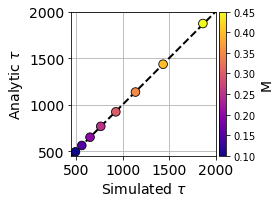

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(4, 4))

# Plot
ax.plot([results[:,1].min()-50, 2000+50], [results[:,1].min()-50, 2000+50],
         'r--', label='Bisettrice', color="black", lw=2)
ax.grid(True)
ax.set_aspect('equal', adjustable='box')

sc = ax.scatter(results[:,1], results[:,2], c=results[:,0],
                cmap='plasma', edgecolor='black', zorder=3, lw=0.8, s=75)

# Colorbar with adjusted size
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)  # size=5% of the main plot
cb = plt.colorbar(sc, cax=cax)
cb.set_label('M', fontsize = 14)

# Labels and legend
#ax.set_title(fr'$\beta={beta_target}, \, N={N}$', fontsize=14)
ax.set_ylabel(r'Analytic $\tau$', fontsize=14)
ax.set_xlabel(r'Simulated $\tau$', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xticks([500, 1000, 1500, 2000])
ax.set_yticks([500, 1000, 1500, 2000])
ax.set_xlim(450, 2000)
ax.set_ylim(450, 2000)
#ax.legend(fontsize=16)
plt.savefig(f"../Plots/FPS_MADE_N{N}_beta{beta_target}.pdf", bbox_inches='tight')
plt.tight_layout()


# Perfectly trained machine

## As a functionn of $\Delta \beta$

In [8]:
def get_beta(m):
    return np.arctanh(m)/m

In [27]:

all_results = []
Ns = [20,50,100, 200, 350, 500, 700]
steps = [2, 2, 2, 4, 6, 8, 16]

#Ns = [20, 200]
#steps = [2,8]

for i, N in enumerate(Ns):
    beta = 1

    W = np.concatenate([np.array([0]),np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
    W *= beta

    probMADE = compute_Pm_abs(N, W)

    results = []
    for M in np.arange(2,int(0.9*N),steps[i]):
        mtarget = M/float(N)
        beta_target = get_beta(mtarget)
        nmax = int((M+1)/2)

        P = get_matrix_mixed(N, beta_target, W, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0]).to(device)-P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

        P = get_matrix_mixed(N, beta_target, W, k=0)[:nmax, :nmax]
        P = torch.eye(P.shape[0]).to(device)-P
        P_inv = torch.linalg.inv(P)
        fpt_made = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]

        #cumulative = probMADE[nmax:].sum()
        #fpt_made = 1/cumulative

        print(beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item())
        results.append((beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item()))
    all_results.append(results)

1.0033534773107557 0.1 1.0654479992479606 2.125285131967 1.9947337959873388
1.0136627702704109 0.2 1.2226386710022312 2.4240434255605825 1.9826327132066959
1.0317320140103725 0.3 1.436565291918808 2.8062216174603773 1.9534243471190444
1.0591223254840045 0.4 1.741444014422888 3.301883731904581 1.8960608004379749
1.0986122886681096 0.5 2.2054220223021574 3.951104475508877 1.7915412268280821
1.1552453009332422 0.6 2.9747081359371768 4.790009343756266 1.6102451483856857
1.2390007538486474 0.7 4.408553262061552 5.7907272143640665 1.3135209829939027
1.373265360835137 0.8 7.57853576154271 6.705501257151342 0.8848016910045364
1.0005338459192052 0.04 1.0368047994194487 2.064306452088459 1.991027099068554
1.0021415629698711 0.08 1.1100143907833981 2.205354470223302 1.9867800710825578
1.0048419034037004 0.12 1.1939150455140897 2.3651868087765315 1.981034427586179
1.0086668508220347 0.16 1.2912548129717207 2.547183979856713 1.9726423896105918
1.0136627702704109 0.2 1.405691779915265 2.755911057468

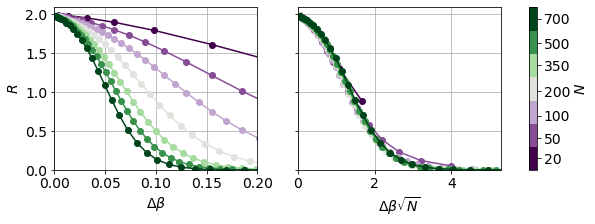

In [40]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Create the custom discrete colormap from your existing custom_cmap.
custom_cmap = mcolors.LinearSegmentedColormap.from_list("ptog", ptog)

Ns = [20, 50, 100, 200, 350, 500, 700]

# Create a discrete colormap using len(Ns) colors.
discrete_colors = custom_cmap(np.linspace(0, 1, len(Ns)))
discrete_cmap = mcolors.ListedColormap(discrete_colors)

# Compute boundaries for the discrete colorbar (midpoints between successive Ns values).
boundaries = [Ns[0] - (Ns[1] - Ns[0]) / 2]
for i in range(len(Ns) - 1):
    boundaries.append((Ns[i] + Ns[i+1]) / 2)
boundaries.append(Ns[-1] + (Ns[-1] - Ns[-2]) / 2)

# Create a norm based on these boundaries.
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(Ns))

# Create a ScalarMappable for the colorbar.
sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])

# Create a 1 x 2 figure.
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# Loop over each result set and plot in both subplots.
for i, results in enumerate(all_results):
    results = np.array(results)
    # Left subplot: original x-axis (Δβ)
    axs[0].plot(results[:, 0] - 1, results[:, -1],
                marker="o", alpha=1, color=discrete_colors[i])
    # Right subplot: x-axis scaled by √N
    axs[1].plot((results[:, 0] - 1) * np.sqrt(Ns[i]), results[:, -1],
                marker="o", alpha=1, color=discrete_colors[i])

# Formatting for the left subplot.
axs[0].set_xlabel(r'$\Delta \beta$', fontsize=14)
axs[0].set_ylabel(r'$R$', fontsize=14)
axs[0].tick_params(labelsize=14)
axs[0].grid(True)
axs[0].set_xlim(0, 0.20)
axs[0].set_ylim(0, None)

# Formatting for the right subplot.
axs[1].set_xlabel(r'$\Delta \beta \sqrt{N}$', fontsize=14)
#axs[1].set_ylabel(r'$R$', fontsize=14)
axs[1].tick_params(labelsize=14)
axs[1].grid(True)
axs[1].set_xlim(0, 0.20 * np.sqrt(max(Ns)))
axs[1].set_ylim(0, None)

# Add a common discretized colorbar.
cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), boundaries=boundaries, ticks=Ns)
cbar.set_label(r'$N$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

#plt.tight_layout()
plt.savefig(f"../Plots/FPS_diffDB.pdf", bbox_inches='tight')
plt.show()

## As a function of the training time

In [ ]:
# Expression of the behaviour of the J(t) i the linearized regime
def Jt_app(t, c, ell, tau, eta):
    return c*tau*(ell-1)*(1-np.exp(-eta*t/tau))

In [15]:
def montecarlo_CW(N, beta, pop_size, num_sweeps):
    # Population of spins, randomly initialized to -1 or 1
    pop = 2.*torch.randint(0, 2, (pop_size, N), device="cuda") - 1.

    
    # Loop to update the population using the Monte Carlo method
    for i in range(0, num_sweeps):  # Maximum number of iterations
        for n in range(N):
            # Perform a Monte Carlo update for the entire population
            pop = monte_carlo_update_CW(pop, N, beta)
        # Perform a Monte Carlo update for the entire population
        pop = monte_carlo_update_CW(pop, N, beta)  
    return pop

In [17]:
#function to perform GD and saving the weights at certain epochs

def train_different_epochs(dataset, input_size, optimal, epochs_save, start = "optimal", pert_type = "uniform_small", epochs=1, optimizer = "SGD", batch_size=256, learning_rate = 0.001):
    """
    Train the MADE architecture using data.

    Parameters:
    - data: Training data as a PyTorch tensor, aka #configurations x #spins tensor.
    - input_size (int): Size of the input features.
    - epochs (int): Number of training epochs.
    - batch_size (int): Batch size for training.
    - learning_rate (float): Learning rate for optimization.

    Returns:
    - model: Trained MADE model.
    """
    data = torch.clone(dataset)
    model = made(input_size)
    model = model.to(device)
    # Set model.layer.weights to optimal, then add a small Gaussian perturbation
    with torch.no_grad():
        if start == "optimal":
            model.layer.weight = nn.Parameter(optimal.clone())
        elif start == "random":
            pass # layers are already initialized randomly 
        elif start == "zero":
            model.layer.weight = nn.Parameter(torch.zeros_like(model.layer.weight))
        else:
            raise ValueError(f"pert_type '{pert_type}' is not supported. Supported types are 'optimal' and 'random'")
        if pert_type == "uniform_small":
            perturbation = 0.01
        elif pert_type == "uniform_large":
            perturbation = 0.3
        elif pert_type == "none":
            perturbation = 0
        else:
            raise ValueError(f"pert_type '{pert_type}' is not supported. Supported types are 'uniform_small', 'uniform_large' and 'none'")
        model.layer.weight += perturbation
    model.train()
    clipper = AutoregressiveMasking()
    model.apply(clipper)

    weights = []

    if optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Optimizer '{optimizer}' is not supported. Supported optimizers are 'SGD' and 'Adam'")
    criterion = nn.BCELoss(reduction="mean")
    for epoch in tqdm(range(epochs)):
        tot_loss = 0
        count = 0
        if epoch in epochs_save:
            with torch.no_grad():
                res = model.layer.weight.sum(1)
                res[1:]/= torch.arange(1, len(res), device = "cuda")
                weights.append(res.cpu().numpy())
        for i in range(0, len(data), batch_size):
            indices = random.sample(range(data.shape[0]), batch_size)
            #batch_data = data[indices]
            batch_data = data[indices].to(device)

            # Forward pass
            output = model(batch_data)

            # Compute loss
            loss = criterion(output, (batch_data + 1) / 2)
            tot_loss += loss
            count += 1

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.apply(clipper)
    
    return model, weights

In [65]:
all_results = []

beta = 1
pop_size = 50000
num_sweeps = 30

coeff = 0.5
Ns = [20,50,100,200,350,500, 700]

times = np.arange(0,1001, 25)

num_epochs = 1001
for i, N in enumerate(Ns):
    results = []
    lr = 1

    W = np.concatenate([np.array([0]),np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
    W *= beta
    model_exact = setup_model(W, N = N)

    beta_target = 1 + coeff/np.sqrt(N)
    mtarget = mhat(beta_target)
    nmax = int((mtarget)*N/2)
    pop = montecarlo_CW(N, beta, pop_size, num_sweeps)
    model, weights  = train_different_epochs(pop, N, model_exact.layer.weight, times, start = "random", pert_type="none", epochs = num_epochs, learning_rate=lr, batch_size=pop_size)

    for count, Wpert in enumerate(weights):

        P = get_matrix_mixed(N, beta_target, Wpert, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0]).to(device)-P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

        P = get_matrix_mixed(N, beta_target, Wpert, k=0)[:nmax, :nmax]
        P = torch.eye(P.shape[0]).to(device)-P
        P_inv = torch.linalg.inv(P)
        fpt_made = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]

        #fpt_made = 1/cumulative

        print(times[count], beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item())
        results.append((times[count], beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item()))
    all_results.append(results)

100%|██████████| 1001/1001 [00:39<00:00, 25.48it/s]


0 1.1118033988749896 0.5267722209710917 18.508977980606584 5.846779828174904 0.3158888531987594
25 1.1118033988749896 0.5267722209710917 2.338373525055449 4.006354026155398 1.7133079823337447
50 1.1118033988749896 0.5267722209710917 2.2150999231396247 3.911887797848224 1.766009630980266
75 1.1118033988749896 0.5267722209710917 2.2022873845729576 3.9018842321222493 1.771741626208724
100 1.1118033988749896 0.5267722209710917 2.1998542764456084 3.8999868453263695 1.7728387225847217
125 1.1118033988749896 0.5267722209710917 2.1992609001546013 3.899521349031688 1.7731053867949744
150 1.1118033988749896 0.5267722209710917 2.1991079625166012 3.8994008135304195 1.7731738868645848
175 1.1118033988749896 0.5267722209710917 2.199069355364191 3.8993703311886847 1.7731911554662652
200 1.1118033988749896 0.5267722209710917 2.1990603928616954 3.899363266032519 1.7731951694869892
225 1.1118033988749896 0.5267722209710917 2.199058510295078 3.899361795921961 1.7731960189630105
250 1.1118033988749896 0.5

100%|██████████| 1001/1001 [00:39<00:00, 25.67it/s]


0 1.0707106781186548 0.43321638618915215 181.81388141332621 8.457897658751639 0.04651953741377918
25 1.0707106781186548 0.43321638618915215 3.6067087146583776 5.246947600589944 1.454774426131312
50 1.0707106781186548 0.43321638618915215 2.7221827303126394 4.603712307070075 1.6911841574064148
75 1.0707106781186548 0.43321638618915215 2.5549910717007784 4.4515831548870155 1.7423086930490659
100 1.0707106781186548 0.43321638618915215 2.5028494542400836 4.402189470296619 1.7588710590798255
125 1.0707106781186548 0.43321638618915215 2.4819552063991175 4.382236851945628 1.7656389771447512
150 1.0707106781186548 0.43321638618915215 2.4721559747787794 4.372850854630936 1.768841003255161
175 1.0707106781186548 0.43321638618915215 2.4670996123182287 4.36799223645674 1.7704969084536974
200 1.0707106781186548 0.43321638618915215 2.46434664907101 4.365337711858217 1.771397588689005
225 1.0707106781186548 0.43321638618915215 2.4628048709850066 4.363846312045822 1.7719009587229246
250 1.0707106781186

100%|██████████| 1001/1001 [00:38<00:00, 25.75it/s]


0 1.05 0.37070573256992784 1907.8865003142946 12.25228321282093 0.006421914097511857
25 1.05 0.37070573256992784 8.788773483322654 8.222699616601167 0.9355912553901118
50 1.05 0.37070573256992784 4.329863821217291 6.327193915638305 1.4612916657179043
75 1.05 0.37070573256992784 3.498774554906136 5.677471225382777 1.6227027881580927
100 1.05 0.37070573256992784 3.204357984420872 5.404353620329765 1.6865636257262626
125 1.05 0.37070573256992784 3.070144267251404 5.27128762494607 1.7169511156768131
150 1.05 0.37070573256992784 2.9996797161871966 5.199324888772235 1.733293344857811
175 1.05 0.37070573256992784 2.9589050057018365 5.157081327456432 1.7429019578251719
200 1.05 0.37070573256992784 2.9335001650006856 5.130555941227464 1.7489536910342274
225 1.05 0.37070573256992784 2.916738689312361 5.112967231209796 1.7529740493877457
250 1.05 0.37070573256992784 2.9051925226087456 5.1008037105249295 1.7557541095227016
275 1.05 0.37070573256992784 2.8969833431468537 5.092125893114248 1.7577339

100%|██████████| 1001/1001 [00:38<00:00, 25.71it/s]


0 1.0353553390593273 0.3156711724359867 54831.674960021395 16.597053655185537 0.0003026909841307365
25 1.0353553390593273 0.3156711724359867 31.61344417278729 12.684834155700415 0.40124809199433775
50 1.0353553390593273 0.3156711724359867 8.176289086860926 9.075592930566865 1.10998924257107
75 1.0353553390593273 0.3156711724359867 5.200500063757477 7.44857827025123 1.4322811612215356
100 1.0353553390593273 0.3156711724359867 4.240559742304004 6.679424201340407 1.575127956506823
125 1.0353553390593273 0.3156711724359867 3.805342993591909 6.2693402182933395 1.6475098903964065
150 1.0353553390593273 0.3156711724359867 3.5714121074991527 6.029990143738727 1.6884050236255626
175 1.0353553390593273 0.3156711724359867 3.4324632821246635 5.881095766769462 1.7133747059718343
200 1.0353553390593273 0.3156711724359867 3.344332370976735 5.784035471773875 1.7295037783833094
225 1.0353553390593273 0.3156711724359867 3.2857101336504364 5.718390856889273 1.7403820252811282
250 1.0353553390593273 0.315

100%|██████████| 1001/1001 [00:39<00:00, 25.64it/s]


0 1.0267261241912424 0.27652547186691834 4953723.413294472 21.283165004946742 4.2963975234928144e-06
25 1.0267261241912424 0.27652547186691834 248.1314636677147 18.44511062141399 0.07433604085822329
50 1.0267261241912424 0.27652547186691834 23.933901939353284 13.925242452932695 0.5818208200325303
75 1.0267261241912424 0.27652547186691834 10.211783574284661 10.801431921135626 1.0577419549250748
100 1.0267261241912424 0.27652547186691834 6.824375753917587 9.068601550310232 1.32885437105428
125 1.0267261241912424 0.27652547186691834 5.457450969378473 8.07528135229171 1.4796800553228555
150 1.0267261241912424 0.27652547186691834 4.757031257544714 7.464348667291609 1.5691191129873392
175 1.0267261241912424 0.27652547186691834 4.3453976933390965 7.064724828240066 1.6257947665110901
200 1.0267261241912424 0.27652547186691834 4.081521685720599 6.790508426256268 1.6637197959803056
225 1.0267261241912424 0.27652547186691834 3.902092852523758 6.595335514539839 1.69020465780925
250 1.0267261241912

100%|██████████| 1001/1001 [00:39<00:00, 25.59it/s]


0 1.022360679774998 0.2539045057902792 30930186.803901274 24.566579281555605 7.942590013215498e-07
25 1.022360679774998 0.2539045057902792 1033.477261453091 22.17273487137434 0.02145449706382413
50 1.022360679774998 0.2539045057902792 56.559895492375716 17.822340259198935 0.3151056080293039
75 1.022360679774998 0.2539045057902792 18.055740488833525 13.92615032044433 0.7712865794153877
100 1.022360679774998 0.2539045057902792 10.291121396697383 11.404517221820639 1.1081899418153367
125 1.022360679774998 0.2539045057902792 7.469491114990177 9.851178412006593 1.3188553624806807
150 1.022360679774998 0.2539045057902792 6.1051599072503615 8.858661293110368 1.4510121647411733
175 1.022360679774998 0.2539045057902792 5.328329147803465 8.192090104717286 1.5374594694650892
200 1.022360679774998 0.2539045057902792 4.837795555698036 7.724017103341102 1.5965984949991585
225 1.022360679774998 0.2539045057902792 4.505559900863512 7.383146586465711 1.6386746040266151
250 1.022360679774998 0.253904505

100%|██████████| 1001/1001 [00:39<00:00, 25.47it/s]


0 1.0188982236504613 0.2341322682996002 415784338.83507955 27.967814119502794 6.726519377295786e-08
25 1.0188982236504613 0.2341322682996002 7477.3067191905075 26.109846632286622 0.003491878508243577
50 1.0188982236504613 0.2341322682996002 197.82559325723452 22.507469553645 0.11377430585727258
75 1.0188982236504613 0.2341322682996002 42.11987365817439 18.354675314525725 0.43577232599233
100 1.0188982236504613 0.2341322682996002 19.055168719555684 15.01828896733199 0.788147782282254
125 1.0188982236504613 0.2341322682996002 11.994806137859577 12.700943354549736 1.0588702483870378
150 1.0188982236504613 0.2341322682996002 8.921220946167674 11.128039981975894 1.2473673782013226
175 1.0188982236504613 0.2341322682996002 7.28641894908907 10.037568175392286 1.377572199118081
200 1.0188982236504613 0.2341322682996002 6.29991008360786 9.257036226970367 1.4693918014888567
225 1.0188982236504613 0.2341322682996002 5.651640405854767 8.680629443367257 1.5359486485330234
250 1.0188982236504613 0.2

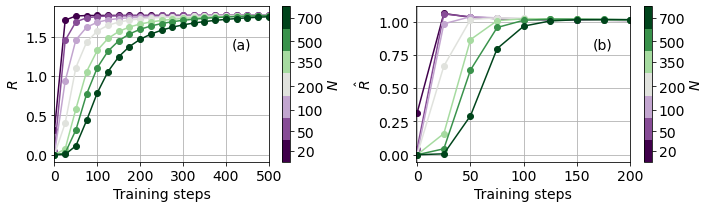

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assumed pre-defined variables: ptog, all_results, data, coeff, and Ns.
Ns = [20, 50, 100, 200, 350, 500, 700]

# Create a custom discrete colormap from the provided ptog colors
custom_cmap = mcolors.LinearSegmentedColormap.from_list("ptog", ptog)
discrete_colors = custom_cmap(np.linspace(0, 1, len(Ns)))
discrete_cmap = mcolors.ListedColormap(discrete_colors)

# Compute boundaries for the discrete colorbar (boundaries halfway between successive Ns values)
boundaries = [Ns[0] - (Ns[1] - Ns[0]) / 2]
for i in range(len(Ns) - 1):
    boundaries.append((Ns[i] + Ns[i+1]) / 2)
boundaries.append(Ns[-1] + (Ns[-1] - Ns[-2]) / 2)

norm = mcolors.BoundaryNorm(boundaries, ncolors=len(Ns))
sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])

# Create a 1x2 figure; note that we are not sharing the y-axis.
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
ax1, ax2 = axes

# ---------------------------
# Left subplot (first plot)
# ---------------------------
for i, results in enumerate(all_results):
    results = np.array(results)
    ax1.plot(results[:, 0], results[:, -1],
             marker="o", alpha=1,
             color=discrete_colors[i],
             label=f'N={Ns[i]}')

ax1.set_xlabel(r'Training steps', fontsize=14)
ax1.set_ylabel(r'$R$', fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
ax1.grid(True)
ax1.set_xlim(0, 500)
# If desired, you can uncomment the following line to add a legend:
# ax1.legend(fontsize=14)

# Add the discretized colorbar to the left subplot
cbar = fig.colorbar(sm, ax=ax2, boundaries=boundaries, ticks=Ns)
cbar.set_label(r'$N$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

cbar = fig.colorbar(sm, ax=ax1, boundaries=boundaries, ticks=Ns)
cbar.set_label(r'$N$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# ---------------------------
# Right subplot (second plot)
# ---------------------------
# Loop over your data and plot each with the corresponding color
for i, d in enumerate(np.array(all_results)):
    ax2.plot(d[:, 0],
             (d[:, 0] + d[:, 4]) / (d[:, 0] + d[:, 3]),
             marker="o", color=discrete_colors[i],
             label=f'N={Ns[i]}')

ax2.set_xlabel(r'Training steps', fontsize=14)
ax2.set_ylabel(r'$\hat{R}$', fontsize=14)
ax2.tick_params(axis='both', labelsize=14)
ax2.set_xlim(-1, 200)
ax2.grid(True)
#ax2.legend(loc='best', fontsize=14)

# Add text labels to the subplots
ax1.text(0.825, 0.80, "(a)", transform=ax1.transAxes, fontsize=14, verticalalignment='top')
ax2.text(0.825, 0.80, "(b)", transform=ax2.transAxes, fontsize=14, verticalalignment='top')

plt.tight_layout()
plt.savefig(f"../Plots/R_vs_trainingtime.pdf", bbox_inches='tight')
plt.show()


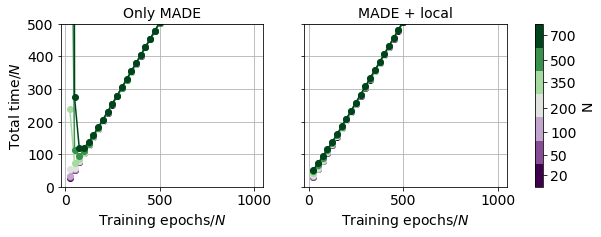

In [59]:
# Create a discrete colormap from ptog
custom_cmap = mcolors.LinearSegmentedColormap.from_list("ptog", ptog)
discrete_colors = custom_cmap(np.linspace(0, 1, len(Ns)))
discrete_cmap = mcolors.ListedColormap(discrete_colors)

# Compute boundaries for the discrete colorbar (midpoints between successive Ns)
boundaries = [Ns[0] - (Ns[1] - Ns[0]) / 2]
for i in range(len(Ns) - 1):
    boundaries.append((Ns[i] + Ns[i+1]) / 2)
boundaries.append(Ns[-1] + (Ns[-1] - Ns[-2]) / 2)

norm = mcolors.BoundaryNorm(boundaries, ncolors=len(Ns))
sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])

# Create figure with 2 subplots (sharing y-axis), size 9x3
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# Left subplot: Plot (d[:,0] + d[:,3])/Ns[i] vs. (d[:,0])/Ns[i] with log-log scaling
for i, d in enumerate(np.array(all_results)):
    axs[0].plot(d[1:, 0],
                (d[1:, 0] + d[1:, 3]),
                marker="o", linestyle='-', color=discrete_colors[i])
axs[0].set_xlabel(r'Training epochs/$N$', fontsize=14)
axs[0].set_ylabel(r'Total time/$N$', fontsize=14)
axs[0].grid(True)
axs[0].set_title('Only MADE', fontsize=14)
#axs[0].set_xscale('log')
#axs[0].set_yscale('log')
axs[0].set_ylim(0, 500)
axs[0].tick_params(labelsize=14)

# Right subplot: Plot (d[:,0] + d[:,4])/Ns[i] vs. (d[:,0])/Ns[i] with log-log scaling
for i, d in enumerate(np.array(all_results)):
    axs[1].plot(d[1:, 0],
                (d[1:, 0] + d[1:, 4]),
                marker="o", linestyle='-', color=discrete_colors[i])
axs[1].set_xlabel(r'Training epochs/$N$', fontsize=14)
axs[1].grid(True)
axs[1].set_title('MADE + local', fontsize=14)
#axs[1].set_xscale('log')
#axs[1].set_yscale('log')
axs[1].tick_params(labelsize=14)

# Add a shared discrete colorbar for the curves using the boundaries computed above.
cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), boundaries=boundaries, ticks=Ns)
cbar.set_label('N', fontsize=14)
cbar.ax.tick_params(labelsize=14)

#plt.tight_layout()
plt.show()

# Comparison with vanilla MADE

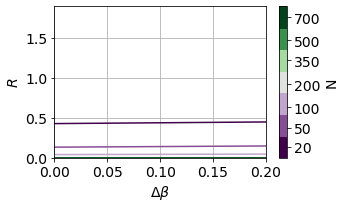

In [24]:
custom_cmap = mcolors.LinearSegmentedColormap.from_list("ptog", ptog)

plt.figure(figsize=(5, 3))

Ns = [20, 50, 100, 200, 350, 500, 700]

# Create a discrete colormap from your existing custom_cmap using len(Ns) colors
discrete_colors = custom_cmap(np.linspace(0, 1, len(Ns)))
discrete_cmap = mcolors.ListedColormap(discrete_colors)

# Compute boundaries for the discrete colorbar.
# We set boundaries midway between successive Ns values.
boundaries = [Ns[0] - (Ns[1] - Ns[0]) / 2]
for i in range(len(Ns) - 1):
    boundaries.append((Ns[i] + Ns[i+1]) / 2)
boundaries.append(Ns[-1] + (Ns[-1] - Ns[-2]) / 2)

# Create a norm based on these boundaries.
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(Ns))

# Create a ScalarMappable for the colorbar.
sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])

# Plot each result using its corresponding discrete color.
for i, results in enumerate(all_results):
    results = np.array(results)
    plt.plot(results[:, 0] - 1, results[:, -1],
             marker="o", alpha=1,
             color=discrete_colors[i])

plt.xlabel(r'$\Delta \beta$', fontsize=14)
plt.ylabel(r'$R$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.xlim(0, 0.20)
plt.ylim(0, None)

# Add the discretized colorbar with ticks at each N.
cbar = plt.colorbar(sm, boundaries=boundaries, ticks=Ns)
cbar.set_label('N', fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
#plt.savefig(f"../Plots/FPS_diffDB.pdf", bbox_inches='tight')
plt.show()